In [109]:
# install libraries
import influxdb_client
import pandas as pd
import secret
from sensor_data_functions import get_sensor_data
from weather_data_functions import get_weather_data
from irradiance_data_functions import irradiance_data, get_lat_long
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import math
import pytz
import ast

In [110]:
year = 2023
month = 12
day = 22
date_time = datetime(year=year, month=month, day=day)

generation_df, consumption_df = get_sensor_data(date_time)

generation_df.head()

Data loaded from local storage
Date is today, querying influxdb to get up to date data


,power
datetime,
2023-12-22 00:00:00+00:00,0.086199
2023-12-22 00:00:01+00:00,0.085664
2023-12-22 00:00:02+00:00,0.086611
2023-12-22 00:00:03+00:00,0.085246
2023-12-22 00:00:04+00:00,0.087097


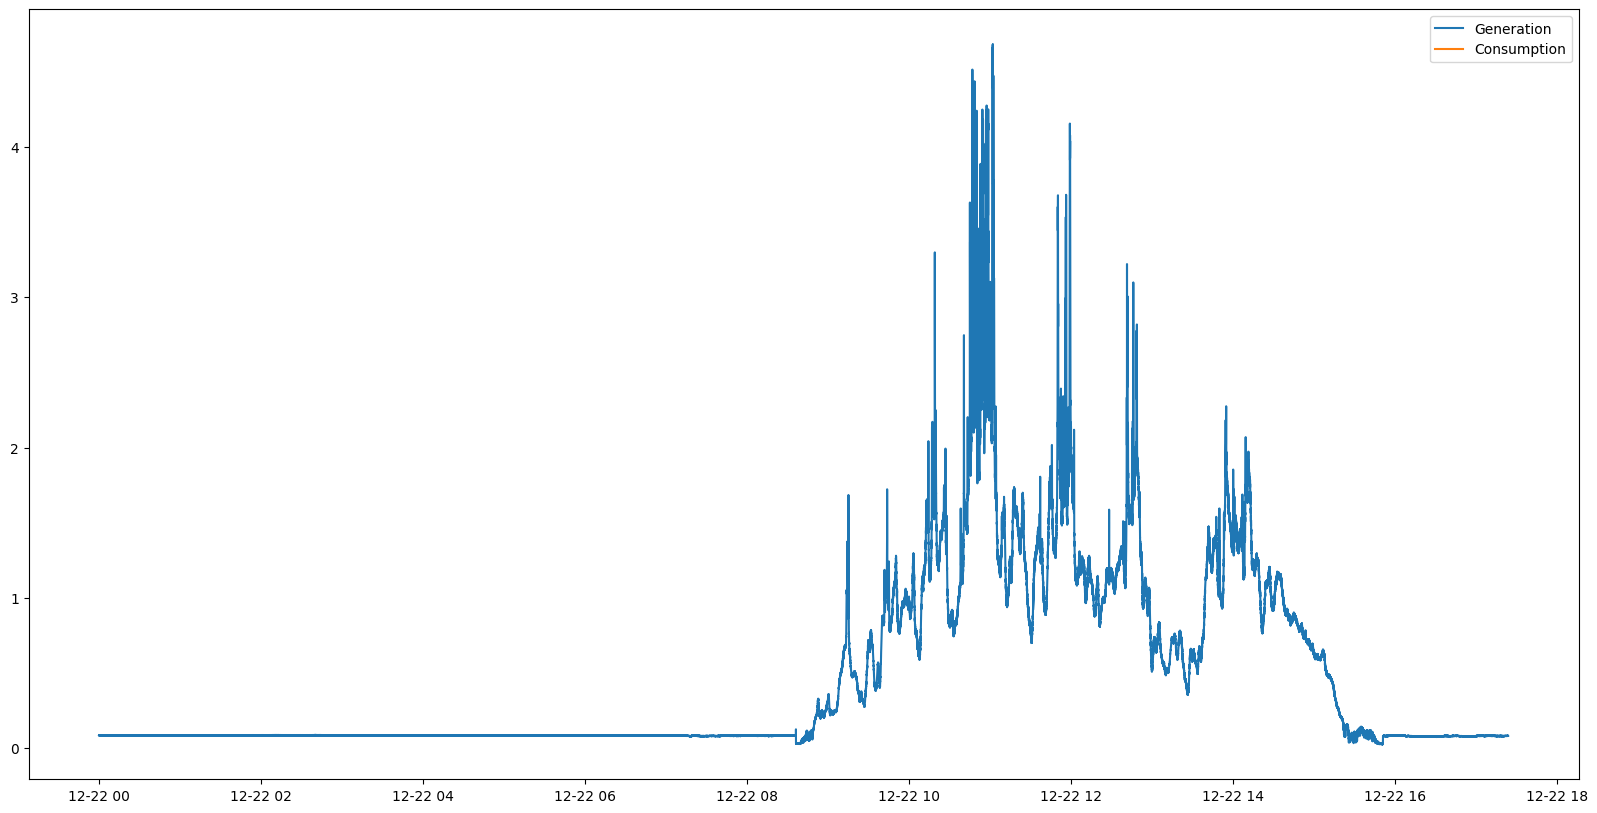

In [111]:
# plot both generation and consumption
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(generation_df.index, generation_df['power'], label='Generation')
ax.plot(consumption_df.index, consumption_df['power'], label='Consumption')
ax.legend()

In [112]:
postcode = 'WR7 4BU'

weather = get_weather_data(postcode, date_time)
weather.head()

Weather data loaded from file


,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,condition
time,,,,,,,,,,,,,,,,,,,,,
2023-12-22 00:00:00,1703203200,9.0,48.2,0,14.3,23.0,283,WNW,1013.0,29.91,...,0,45,0,0,10.0,6.0,21.7,35.0,1.0,Patchy rain possible
2023-12-22 01:00:00,1703206800,9.1,48.4,0,15.0,24.1,275,W,1012.0,29.89,...,1,100,0,0,2.0,1.0,23.0,37.0,1.0,Light drizzle
2023-12-22 02:00:00,1703210400,10.3,50.5,0,20.1,32.4,287,WNW,1012.0,29.89,...,1,100,0,0,2.0,1.0,30.7,49.4,1.0,Light drizzle
2023-12-22 03:00:00,1703214000,10.4,50.8,0,20.8,33.5,288,WNW,1012.0,29.89,...,1,100,0,0,10.0,6.0,31.7,51.0,1.0,Patchy rain possible
2023-12-22 04:00:00,1703217600,10.3,50.6,0,21.7,34.9,286,WNW,1012.0,29.89,...,1,100,0,0,10.0,6.0,32.9,52.9,1.0,Patchy rain possible


In [113]:
irradiance = irradiance_data(postcode, date_time)
irradiance

Locally available data used


,start,end,start_time,clear_sky_ghi,clear_sky_dni,clear_sky_dhi,cloudy_sky_ghi,cloudy_sky_dni,cloudy_sky_dhi
0,00:00,00:15,2023-12-22 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,00:15,00:30,2023-12-22 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0
2,00:30,00:45,2023-12-22 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
3,00:45,01:00,2023-12-22 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0
4,01:00,01:15,2023-12-22 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
91,22:45,23:00,2023-12-22 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0
92,23:00,23:15,2023-12-22 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0
93,23:15,23:30,2023-12-22 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0
94,23:30,23:45,2023-12-22 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0


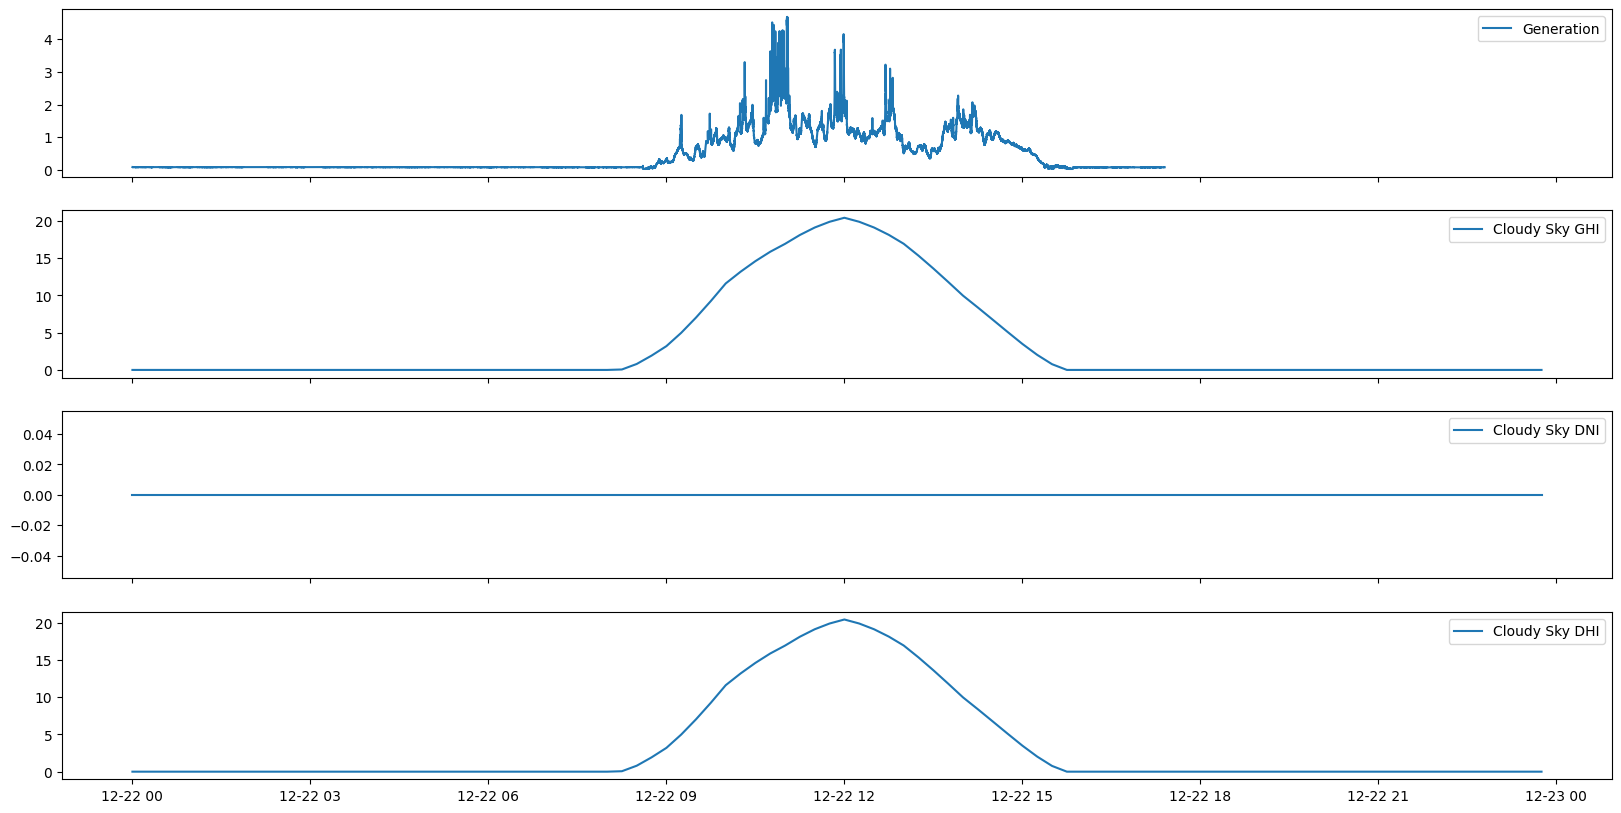

In [114]:
# plot the irradiance data and sensor data on the same graph
fig, ax = plt.subplots(figsize=(20, 10), nrows=4, sharex=True)

ax[1].plot(irradiance['start_time'], irradiance['cloudy_sky_ghi'], label='Cloudy Sky GHI')
ax[2].plot(irradiance['start_time'], irradiance['cloudy_sky_dni'], label='Cloudy Sky DNI')
ax[3].plot(irradiance['start_time'], irradiance['cloudy_sky_dhi'], label='Cloudy Sky DHI')
# ax[1].plot(irradiance['start_time'], irradiance['clear_sky_ghi'], label='Clear Sky GHI')
# ax[1].plot(irradiance['start_time'], irradiance['clear_sky_dni'], label='Clear Sky DNI')
# ax[1].plot(irradiance['start_time'], irradiance['clear_sky_dhi'], label='Clear Sky DHI')
ax[0].plot(generation_df.index, generation_df['power'], label='Generation')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()